# Python Notebook for Facial Expression Classification Research Paper Model

In this notebook, our research paper classification model is defined and trained and then validated by our validation dataset.

## Dowloading Data (FER 2013):

Installing **Kaggle** Package Manager for downloading data from Kaggle.

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here we are making directory where we want to place **kaggle.json** so that kaggle package can get permission to download the dataset.

In [ ]:
! mkdir ~/.kaggle

Copy the **kaggle.json** to our created directory.

In [ ]:
!cp kaggle.json ~/.kaggle/

Adding Security permissions to the file.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Download the dataset in zip format.

In [ ]:
!kaggle datasets download -d msambare/fer2013

 99% 60.0M/60.3M [00:03<00:00, 23.3MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.8MB/s]


Unzip the data in the root folder.

In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

## Importing Libraries:

Here are the some required libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Transformations and Data Loaders:

The transformations are defined using the transforms module from PyTorch. The Grayscale transformation converts the image to grayscale with a single output channel. The ToTensor transformation converts the input image to a PyTorch tensor. Finally, the Normalize transformation normalizes the pixel values of the tensor using the mean and standard deviation specified in the mean and std arrays.

In this specific example, the mean is [0.5] and the standard deviation is [0.25]. The Normalize transformation divides each pixel value by the standard deviation and subtracts the mean. This results in the pixel values having a zero mean and unit variance, which is a commonly used preprocessing step in deep learning.

It's worth noting that these transformations are only applied to the training data, not the validation or test data. This is because we want to avoid introducing any bias into the validation and test sets that could affect the accuracy of the model's predictions.
Free Research Preview. ChatGPT may produce inaccurate information about people, places, or facts. ChatGPT May 12 Version

In [ ]:
mean = np.array([0.5,])
std = np.array([0.25,])
train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

This code loads the training and test datasets and creates data loaders for them.

The ImageFolder function from torchvision.datasets is used to create datasets from images in directories. In this case, the training and test images are located in ./train and ./test directories, respectively. The transform argument specifies the transformations to be applied to the images, which are defined in the train_transforms variable for the training dataset, and a separate set of ToTensor and Normalize transformations for the test dataset.

The DataLoader function from torch.utils.data is used to create data loaders that can load the data in batches during training and testing. The batch_size argument specifies the number of images in each batch, and the shuffle argument indicates whether the data should be shuffled before each epoch. The training and test loaders are created separately, with different batch sizes, but both with shuffling enabled.

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('./train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./test', transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
images, labels = next(iter(train_loader))
input_features = images.shape[1]
batch_size = images.shape[0]
out_features = labels.shape[0]
hidden_features = 16

In [ ]:
images.shape

torch.Size([128, 1, 48, 48])

Here is the dictionary for converting index to classes and classes to index.

In [ ]:
class2index = train_dataset.class_to_idx
index2class = dict([(value, key) for key, value in class2index.items()])

Here is the pictorial representaion of images in our dataset

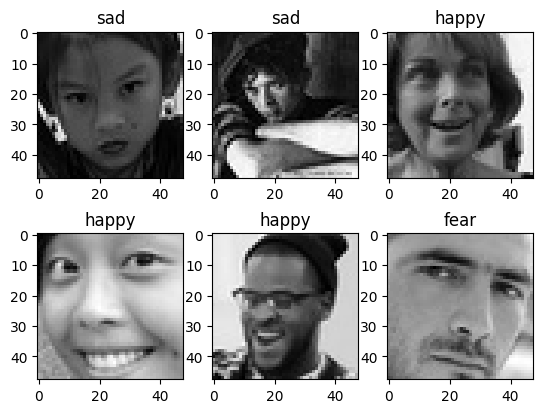

In [ ]:
images, labels = next(iter(test_loader))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(images[i][0], cmap="gray")
  plt.title(index2class[labels[i].item()])
plt.show()

## Model Creation:

This is a PyTorch module that defines a convolutional neural network (CNN) architecture called Deep_Emotion for emotion recognition. It inherits from the nn.Module class, which is the base class for all neural network modules in PyTorch.

The __init__ method defines the layers of the CNN, which include convolutional layers, max pooling layers, batch normalization layers, fully connected layers, and a spatial transformer network (STN). The STN is a type of attention mechanism that allows the network to selectively focus on certain regions of the input image.

The stn method implements the spatial transformer network. It takes an input tensor and applies a series of convolutional layers and linear layers to compute a set of affine transformation parameters. These parameters are then used to generate a grid of sampling points, which are used to transform the input tensor. The transformed tensor is then returned as the output of the method.

The forward method defines the forward pass of the CNN. It takes an input tensor and passes it through the STN, followed by several convolutional layers, max pooling layers, and fully connected layers. The output of the last fully connected layer is the network's prediction for the emotion label of the input image.

Overall, the Deep_Emotion CNN architecture is designed to take in grayscale images of facial expressions and output a probability distribution over 7 possible emotion labels: angry, disgusted, fearful, happy, neutral, sad, and surprised.
<br><br><br>
The **Pictorial Represention** of the Model is given below:
<br><br>
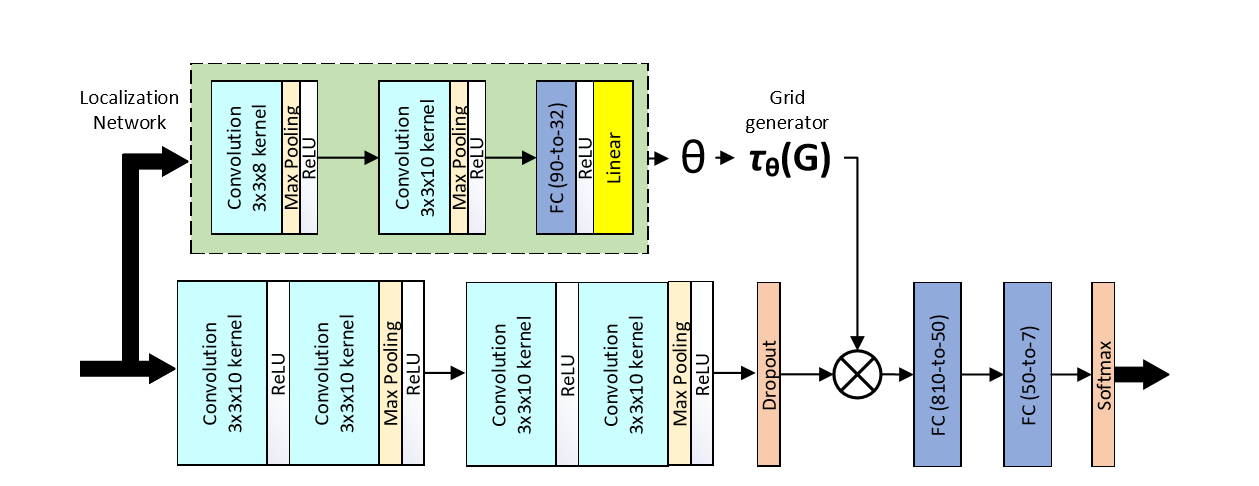

In [ ]:
import torch
import torch.nn as nn

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out


The code then trains the model on a training dataset and validates it on a test dataset for a specified number of epochs. During each epoch, the model is first set to training mode and trained on batches of data using ADAM optimizer with a cross-entropy loss function. Then, the model is set to evaluation mode and evaluated on the test dataset to calculate its accuracy.

The history dictionary is used to store the loss and accuracy values during the training process. The best model is saved based on the lowest loss and highest accuracy values achieved during the training process.

Overall, the given code is an implementation of a CNN model using PyTorch for image classification, with training and validation on a dataset, and a mechanism to save the best model based on loss and accuracy.

In [ ]:
learning_rate = 0.005
model = Deep_Emotion().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50
history = {
    "Loss": [],
    "Accuracy": []
}

best_loss = float('inf')
best_acc = 0.0

for epoch in range(epochs):
    model.train()  # Set model to training mode

    acc_loss = 0
    for i, (input, labels) in enumerate(train_loader):
        input = input.to(device)
        labels = labels.to(device)

        y_pred = model(input)
        l = loss(y_pred, labels)
        acc_loss += l.item()

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    avg_loss = acc_loss / len(train_dataset)  # Calculate average loss per sample
    history['Loss'].append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}]:")
    print(f"Train Loss: {avg_loss:.3f}")

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        n_correct = 0
        for input, labels in test_loader:
            input = input.to(device)
            labels = labels.to(device)
            y_pred_test = model(input)
            _, index = torch.max(y_pred_test, 1)
            n_correct += (labels == index).sum().item()
        acc = n_correct / len(test_dataset)  # Calculate accuracy on test dataset
        print(f"Test Accuracy: {acc:.3f}")
        history['Accuracy'].append(acc)

        # Save model based on loss and accuracy
        if avg_loss < best_loss and acc > best_acc:
            best_loss = avg_loss
            best_acc = acc
            torch.save(model.state_dict(), "best_model_loss.pth")
            print("Best model saved!")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch [1/50]:
Train Loss: 0.013
Test Accuracy: 0.373
Best model saved!
Epoch [2/50]:
Train Loss: 0.012
Test Accuracy: 0.414
Best model saved!
Epoch [3/50]:
Train Loss: 0.011
Test Accuracy: 0.436
Best model saved!
Epoch [4/50]:
Train Loss: 0.011
Test Accuracy: 0.439
Best model saved!
Epoch [5/50]:
Train Loss: 0.011
Test Accuracy: 0.440
Best model saved!
Epoch [6/50]:
Train Loss: 0.011
Test Accuracy: 0.461
Best model saved!
Epoch [7/50]:
Train Loss: 0.011
Test Accuracy: 0.473
Best model saved!
Epoch [8/50]:
Train Loss: 0.011
Test Accuracy: 0.466
Epoch [9/50]:
Train Loss: 0.011
Test Accuracy: 0.469
Epoch [10/50]:
Train Loss: 0.010
Test Accuracy: 0.456
Epoch [11/50]:
Train Loss: 0.010
Test Accuracy: 0.484
Best model saved!
Epoch [12/50]:
Train Loss: 0.010
Test Accuracy: 0.462
Epoch [13/50]:
Train Loss: 0.010
Test Accuracy: 0.478
Epoch [14/50]:
Train Loss: 0.010
Test Accuracy: 0.478
Epoch [15/50]:
Train Loss: 0.010
Test Accuracy: 0.476
Epoch [16/50]:
Train Loss: 0.010
Test Accuracy: 0.496
B

## Model Testing:

Here are the cells that calculates the overall accuracy and then plot the training cycle of the given model.

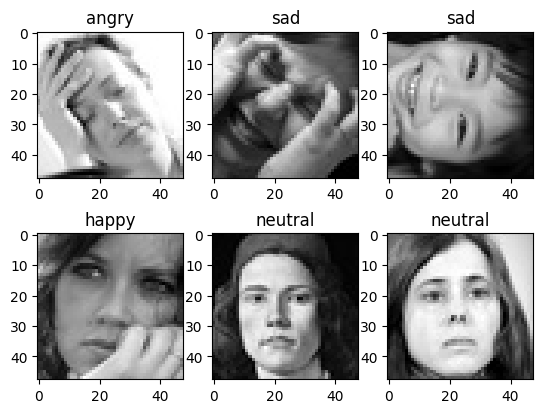

In [ ]:
model.eval()
images, labels = next(iter(test_loader))
for i in range(6):
  input = images[i].to(device)
  input = torch.unsqueeze(input, axis=0)
  y_pred_test = model(input)
  value, index = torch.max(y_pred_test, 1)
  plt.subplot(2, 3, i+1)
  plt.imshow(images[i][0], cmap="gray")
  plt.title(index2class[index.item()])
plt.show()

Here is the plot of the trend of loss and accuracy in the training of our model.

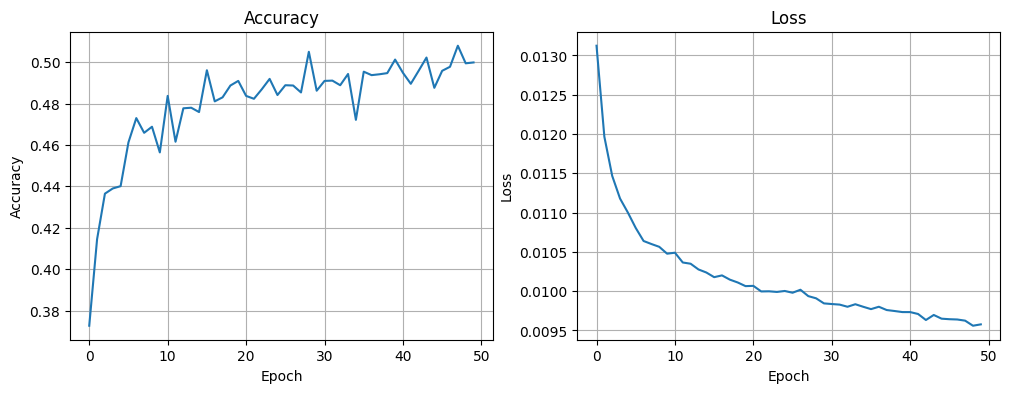

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['Accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['Loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

## Load Our Saved Model and Test:

In [ ]:
load_model = model.to(device)
checkpoint_path = '/content/best_model_loss.pth'
checkpoint = torch.load(checkpoint_path)
load_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
load_model.eval()
pred_labels = np.array([])
actual_labels = np.array([])
with torch.no_grad():
  n_correct = 0
  for input, labels in test_loader:
    input = input.to(device)
    labels = labels.to(device)
    y_pred_test = load_model(input)
    _, index = torch.max(y_pred_test, 1)
    pred_labels = np.append(pred_labels, index.cpu().numpy())
    actual_labels = np.append(actual_labels, labels.cpu().numpy())
    n_correct += (labels == index).sum().item()
  acc = n_correct/(len(test_loader)*100)
  print(f"Accuracy :: {acc}")

Accuracy :: 0.6291228070175439


Here are our **Evaluation Metrics** for the testing of our model

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true=actual_labels, y_pred=pred_labels)

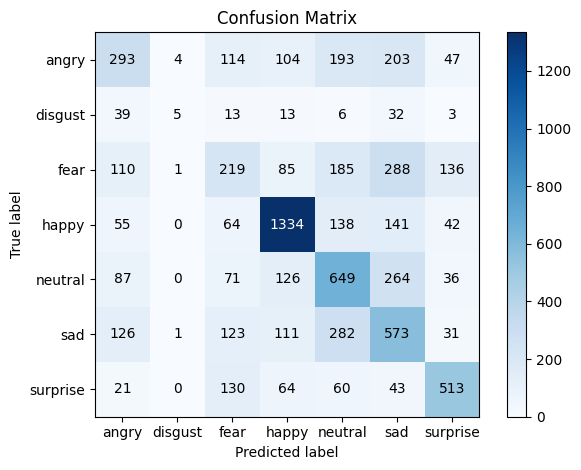

In [ ]:
# Define class labels
class_labels = list(class2index.keys())

# Create figure and axis
fig, ax = plt.subplots()

# Plot confusion matrix
im = ax.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels
ax.set(xticks=np.arange(confusion_mat.shape[1]),
       yticks=np.arange(confusion_mat.shape[0]),
       xticklabels=class_labels, yticklabels=class_labels,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and add text annotations
thresh = confusion_mat.max() / 2.
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(j, i, format(confusion_mat[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_mat[i, j] > thresh else "black")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(actual_labels,pred_labels, target_names=list(class2index.keys()))
print(report)

              precision    recall  f1-score   support

       angry       0.40      0.31      0.35       958
     disgust       0.45      0.05      0.08       111
        fear       0.30      0.21      0.25      1024
       happy       0.73      0.75      0.74      1774
     neutral       0.43      0.53      0.47      1233
         sad       0.37      0.46      0.41      1247
    surprise       0.63      0.62      0.63       831

    accuracy                           0.50      7178
   macro avg       0.47      0.42      0.42      7178
weighted avg       0.49      0.50      0.49      7178

